# Getting Started

## Obtain/Scrub

If you want to follow along in your own drive, the first step you'll need to take is to download the LISA dataset. Click [here](https://drive.google.com/file/d/1vdfuAMbCdKFt_hn_10zkzV258VUJHNCO/view?usp=sharing) to access a modified version of the zip file to place in your own Google Drive. This modified zip file contains an additional set of screenshots from Google Images and Google Street View, located in the folder `prediction_images`. 

Once the zip file is in the Drive directory you want it in, the following blocks of code will unzip the data within Google Colab.

In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
%cd ~
%cd ..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/root
/


In [2]:
import os,glob

print(os.path.abspath(os.curdir))

# change the next line of code to reflect the location of the zip file in your own Drive
source_folder = r'/gdrive/My Drive/Datasets/' 
file = glob.glob(source_folder+'*.zip',recursive=True)[0]
file

/


'/gdrive/My Drive/Datasets/LISA_dataset.zip'

In [0]:
zip_path = file

!cp "{zip_path}" .

!unzip -q LISA_dataset.zip 
!rm LISA_dataset.zip 

After the above cells run, the below cell will check to see if we've gotten all the directories we need.

In [4]:
print(os.path.abspath(os.curdir))
os.listdir()

/


['dev',
 'media',
 'sbin',
 'boot',
 'run',
 'root',
 'sys',
 'mnt',
 'opt',
 'var',
 'usr',
 'lib',
 'proc',
 'srv',
 'bin',
 'etc',
 'home',
 'lib64',
 'tmp',
 'vid8',
 'vid9',
 'models',
 'gdrive',
 'vid4',
 'vid7',
 'vid0',
 'vid11',
 'aiua120306-1',
 'vid10',
 'prediction_images',
 'aiua120306-0',
 'aiua120214-0',
 'vid1',
 'vid3',
 'aiua120214-2',
 'vid2',
 'vid6',
 'allAnnotations.csv',
 'aiua120214-1',
 'vid5',
 '.dockerenv',
 'tools',
 'datalab',
 'swift',
 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl',
 'tensorflow-1.15.2',
 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl',
 'content',
 'lib32']

## Explore 

Now we're ready to import a few packages and explore our data. Fortuitously, the annotations are stored in a convenient CSV for us, complete with bounding box coordinates. While bounding boxes are outside the scope of this project in its current form, they are planned to be implemented in a future update.

In [0]:
%tensorflow_version 2.x

In [6]:
import tensorflow as tf

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.2.0-rc2


[]

The `allAnnotations` CSV will be invaluable in accessing the filenames of the individual pictures that we will collect to form our train-test split. Let's import that now.

Word of note: Only the images from the original LISA dataset have annotations stored within the `allAnnotations.csv` file. The images within the `prediction_images` folder do not have annotations. 

In [7]:
import pandas as pd

annotations = pd.read_csv('allAnnotations.csv', sep=';')
annotations.head()

Filename  ... Origin track frame number
0  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
1  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
2  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         7
3  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         7
4  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                        12

[5 rows x 11 columns]

Now that we've imported our dataframe, let's take a look at the class prevalence, as well as investigate any class imbalance that may be present.

In [8]:
labels = annotations['Annotation tag'].nunique()
pictures = annotations['Filename'].nunique()

print(f"There are {labels} unique labels across {pictures} unique pictures.")

There are 47 unique labels across 6618 unique pictures.


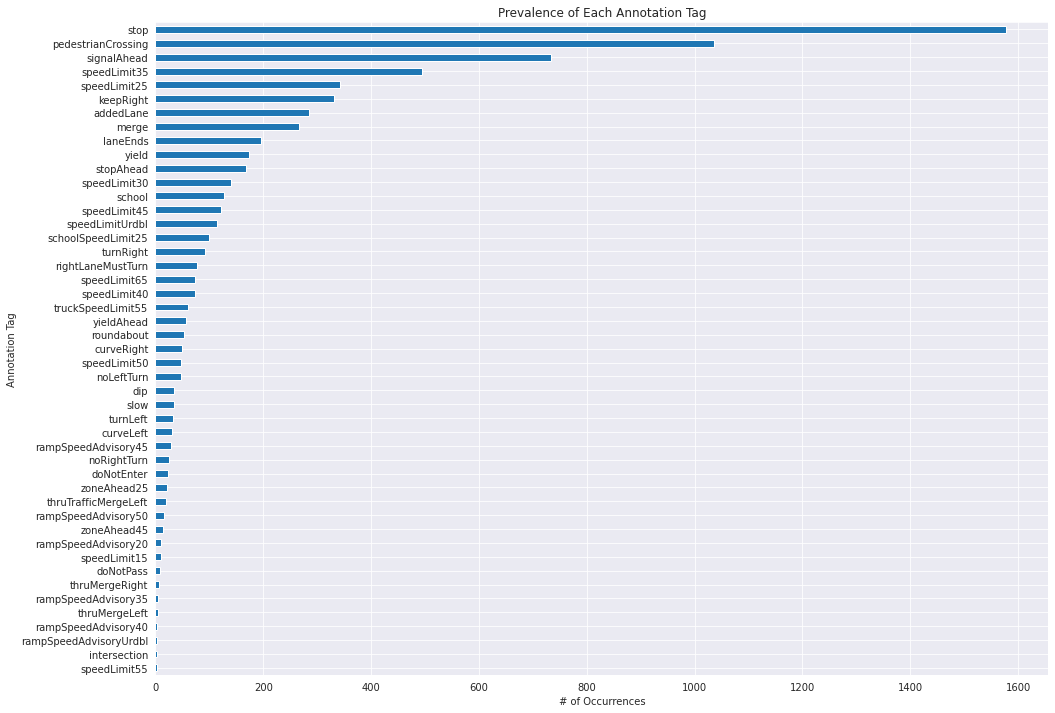

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

x = annotations.groupby('Annotation tag')['Filename'].nunique().sort_values(ascending=True)

plt.figure(figsize=(16,12))
x.plot(kind='barh')
plt.ylabel('Annotation Tag')
plt.xlabel('# of Occurrences')
plt.title('Prevalence of Each Annotation Tag')
plt.show()

At this point, we should investigate the number of images with more than one annotation. For simplicity's sake, we'll eliminate all occurrences of this happening by dropping any row in `annotations` with a duplicate `Filename`. Afterwards, we'll replot the above graph according to our new statistics.

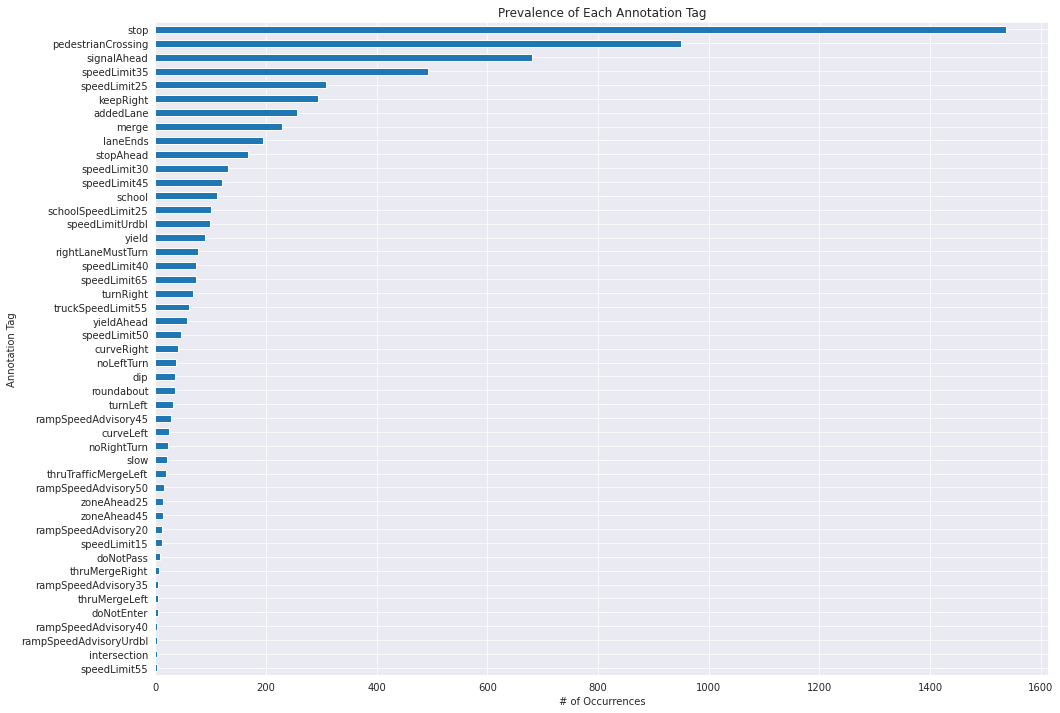

In [13]:
annotations.drop_duplicates(subset='Filename',
                            keep='first',
                            inplace=True)

x = annotations.groupby('Annotation tag')['Filename'].nunique().sort_values(ascending=True)

plt.figure(figsize=(16,12))
x.plot(kind='barh')
plt.ylabel('Annotation Tag')
plt.xlabel('# of Occurrences')
plt.title('Prevalence of Each Annotation Tag')
plt.show()

Due to the number of unique labels, as well as the large imbalance in class occurrence, we'll only take a look at the top 5 most common classes in order to train our model. Naturally, we'll only test this model on those 5 classes as well.

In [14]:
print(annotations['Annotation tag'].value_counts()[:5])

sum(annotations['Annotation tag'].value_counts()[:5])

stop                  1537
pedestrianCrossing     950
signalAhead            681
speedLimit35           492
speedLimit25           308
Name: Annotation tag, dtype: int64


3968

In [0]:
tags = ['pedestrianCrossing','signalAhead','speedLimit25','speedLimit35','stop']

clippedAnnotations = annotations[(annotations['Annotation tag'] == tags[0]) |
                                 (annotations['Annotation tag'] == tags[1]) |
                                 (annotations['Annotation tag'] == tags[2]) |
                                 (annotations['Annotation tag'] == tags[3]) |
                                 (annotations['Annotation tag'] == tags[4])]

clippedAnnotations = clippedAnnotations.reset_index(drop=True)
total = len(clippedAnnotations)
unique = clippedAnnotations['Filename'].nunique()

clippedAnnotations.head()

Filename  ... Origin track frame number
0  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
1  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         7
2  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                        12
3  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
4  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         9

[5 rows x 11 columns]

In [0]:
print(f"There are {unique} unique filenames and {total} total images.")

There are 3968 unique filenames and 3968 total images.


Perfect. All duplicity has been eliminated, and we can continue with data scrubbing. At this point, we should consider that our pictures not only might have different resolutions, but different aspect ratios as well. To test this claim, we'll open each individual image, extract its dimensions, and append those to lists for height and width. 

On our way, we'll calculate the mean and the standard deviation of all the aspect ratios.

In [0]:
import numpy as np
import os
from PIL import Image

widths = []
heights = []

for filename in list(clippedAnnotations['Filename']):
    image = Image.open(filename) 
    orig_w, orig_h = image.size
    widths.append(orig_w)
    heights.append(orig_h)

aspect_ratios = np.array(np.array(widths)/np.array(heights))

# having lists of values is a convenient way to add them to our dataframe
clippedAnnotations['imageWidth'] = widths
clippedAnnotations['imageHeight'] = heights
clippedAnnotations['aspectRatio'] = aspect_ratios

clippedAnnotations.head()

Filename  ... aspectRatio
0  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
1  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
2  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
3  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
4  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686

[5 rows x 14 columns]

In [0]:
clippedAnnotations['aspectRatio'].value_counts()

1.961686    2213
1.466667    1232
1.333333     523
Name: aspectRatio, dtype: int64

At this point, we have a decision to make. The model that is about to be created can only take in one unique image size, and therefore one unique aspect ratio, but to which ratio should all of our images be converted? Should it be the mode, i.e. 1.96? That would cause no distortion to the majority of our images, but quite a bit of distortion to a not insignificant fraction of our data. Should it then be the unweighted average, 1.59, or should it be the weighted average, 1.73? 

Resizing our data to the weighted average seems like a good middle ground to explore. Note that there are [ways](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) of creating models that accept multiple input sizes, but that is outside the scope of this project in its current state. Thus, we will forge ahead with our target aspect ratio of 1.73. A good resolution that has this approximate aspect ratio is 400x230.

Due to our relatively small dataset, we'll create a 95-5 split for training and validation. 

In [0]:
# resize image while preserving average aspect ratio
# send modified images to new directory

import random

test_dir = 'resized_images_400x230/test/'
train_dir = 'resized_images_400x230/train/'

if os.path.isdir('resized_images_400x230'):

  train_count = 3757
  test_count = 211
  
  print("Split was already created. Continuing...")

else:

  print("Creating split...")

  random.seed(42) # create seed for reproducibility

  os.makedirs(test_dir) 
  os.makedirs(train_dir)

  test_count = 0
  train_count = 0

  for tag in tags: 
    
    for index, row in clippedAnnotations[clippedAnnotations['Annotation tag'] == tag].iterrows():
    
      filename = row['Filename']
      image = Image.open(row['Filename'])
      target_w, target_h = 400, 230 # preserves 1.74 mean aspect ratio
      image = image.resize((target_w, target_h), Image.LANCZOS)
            
      # RNG way of creating 95-5 train-test split
      num = random.randint(1,100)
      if num > 95:
        test_count += 1
        resized_dir = os.path.join(test_dir, tag)
        os.makedirs(resized_dir, exist_ok=True)
        
      else:
        train_count += 1
        resized_dir = os.path.join(train_dir, tag)
        os.makedirs(resized_dir, exist_ok=True)
        
      image.save((resized_dir+'/'+str(index)+'.png'), format='png')
  
  print("Train/test split completed successfully. Continuing...")

Creating split...
Train/test split completed successfully. Continuing...


In [0]:
print(train_count, test_count)

3757 211


## Model #1

At last, we're ready to create a classification model for training. For purposes of the `ImageDataGenerator` instance for the training data generator, we do not use any zooming due to many of the traffic signs occurring at the very edge of the picture to begin with. Zooming in would cut off those traffic signs and throw off the data. 

Additionally, we do not use horizontal or vertical flipping, as real-world orientation plays a big part in determining what the sign actually means. For example, a "No Right Turn" sign flipped horizontally becomes a "No Left Turn" sign, and would therefore be misclassified by the model. 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_batch_size = 30
val_batch_size = 10

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=0.2,
                                   shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(230, 400),
        batch_size=train_batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(230, 400),
        batch_size=val_batch_size,
        class_mode='categorical')

Using TensorFlow backend.


Found 3757 images belonging to 5 classes.
Found 211 images belonging to 5 classes.


### Word of note 

Models were trained within this notebook on the first run of this code. On all subsequent runs, however, the models were loaded from saved weight files. The code remains in full here for transparency's sake, but if you'd like to skip the actual training and validation, you can scroll past these cells and load the models from the weight files. 

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(230,400,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 228, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 199, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 114, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 195, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 97, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 97, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 95, 128)       7

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

def create_csvlogger(filename):
    return CSVLogger(filename, separator=',', append=False)

def create_checkpoint(monitor='val_acc',model_subfolder='/gdrive/My Drive/Datasets/models/'):
    filepath=model_subfolder+"weights-improvement-{epoch:02d}-{"+monitor+":.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, mode='max')
    return checkpoint

def create_early_stopping(monitor = 'val_acc',min_delta = 0, patience = 3,
                          verbose = 1, restore_best_weights = True):

    args = locals()
    earlystop = EarlyStopping(**args)
    return earlystop

In [0]:
model_subfolder='/gdrive/My Drive/Datasets/models/'
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log.csv')]
callbacks_list

In [0]:
train_steps = train_count//train_batch_size
val_steps = test_count//val_batch_size

print(train_steps, val_steps)

125 20


In [0]:
history = model.fit(train_generator, 
                    steps_per_epoch=(train_count//train_batch_size), 
                    epochs=25, 
                    validation_data=validation_generator, 
                    validation_steps=test_count//val_batch_size,
                    callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 20 steps
Epoch 1/25
124/125 [============================>.] - ETA: 0s - loss: 1.4482 - acc: 0.3922
Epoch 00001: val_acc improved from -inf to 0.44000, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-01-0.44.hdf5
125/125 [==============================] - 80s 642ms/step - loss: 1.4502 - acc: 0.3904 - val_loss: 1.5462 - val_acc: 0.4400
Epoch 2/25
124/125 [============================>.] - ETA: 0s - loss: 1.3989 - acc: 0.4176
Epoch 00002: val_acc improved from 0.44000 to 0.44500, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-02-0.44.hdf5
125/125 [==============================] - 76s 609ms/step - loss: 1.3999 - acc: 0.4166 - val_loss: 1.4947 - val_acc: 0.4450
Epoch 3/25
124/125 [============================>.] - ETA: 0s - loss: 1.3616 - acc: 0.4373
Epoch 00003: val_acc did not improve from 0.44500
125/125 [==============================] - 76s 607ms/step - loss:

This model apparently attained 85.5% validation accuracy. Not bad, especially for a preliminary model! We can definitely do better, but let's figure out *how* to do better first, by visualizing the prediction results.

In [0]:
# skipping model compilation/training 
from tensorflow.keras import models

model = models.load_model('/models/weights-improvement-14-0.86.hdf5')

### Visualizing Results

At this point, we should take a look at some of the images and how our model classifies them. Below is a function that outputs the input image, which will be selected from the `test` folder, and a bar graph showing the confidence levels for each label predicted by the model.

In [0]:
def img_path_to_array(image_path):

  from matplotlib import image
  import numpy as np

  img = image.imread(image_path)
  img_array = np.expand_dims(img, axis=0)

  return img, img_array

In [0]:
label_dict = {'stop': 'Stop',
              'speedLimit25': '25 MPH Speed Limit',
              'speedLimit35': '35 MPH Speed Limit',
              'pedestrianCrossing': 'Pedestrian Crossing',
              'signalAhead': 'Signal Ahead'}

def make_prediction_graph(image_path, model):
  import matplotlib.pyplot as plt
  import seaborn as sns

  sns.set_style('darkgrid')
  
  img, img_array = img_path_to_array(image_path)

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,7))

  # settings for the picture displayed on the left
  file_folder = image_path.split('/')[3]
  sign_type = label_dict[file_folder]
  ax1.imshow(img)
  ax1.axis('off')
  ax1.set_title(f'Raw Image: {sign_type} Sign')

  # settings for the bar graph displayed on the right
  # first we grab the confidence levels predicted by the model
  preds = model.predict(img_array).tolist()[0]

  # we'll highlight the highest value in red, otherwise grey
  colors = ['grey' if (x < max(preds)) else 'firebrick' for x in preds]

  # next we grab the prettified labels sorted alphanumerically by their keys
  labels = [label_dict[x] for x in train_generator.class_indices.keys()]

  ax2.bar(x=labels, height=preds, color=colors)
  ax2.set_xlabel('Prediction Label')
  ax2.set_ylabel('Confidence Level')
  ax2.set_title('Confidence Levels of Each Label')
  
  return 

Below is a selection of images from each label. Sometimes the model gets it right...

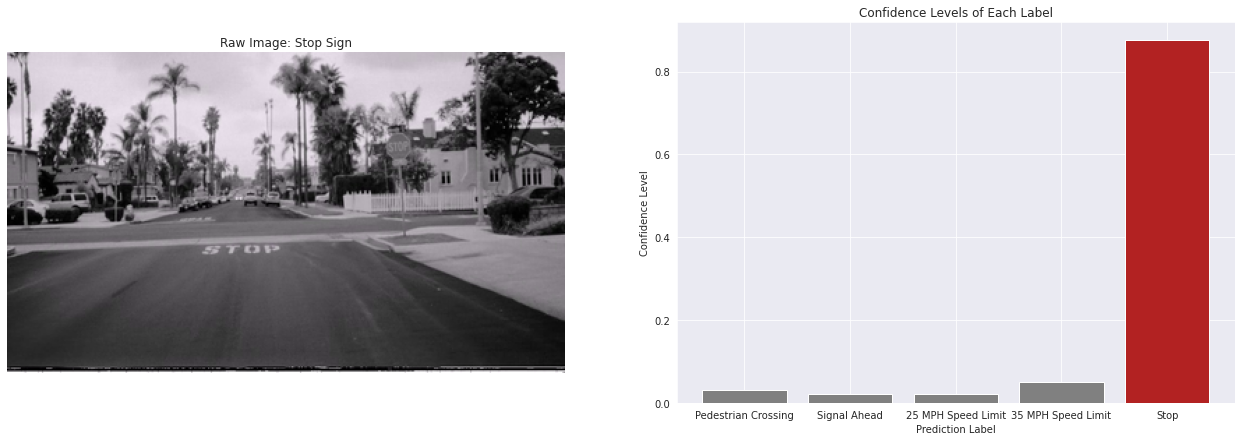

In [0]:
make_prediction_graph('/resized_images_400x230/test/stop/1026.png',
                      model)

And sometimes it gets them very wrong.

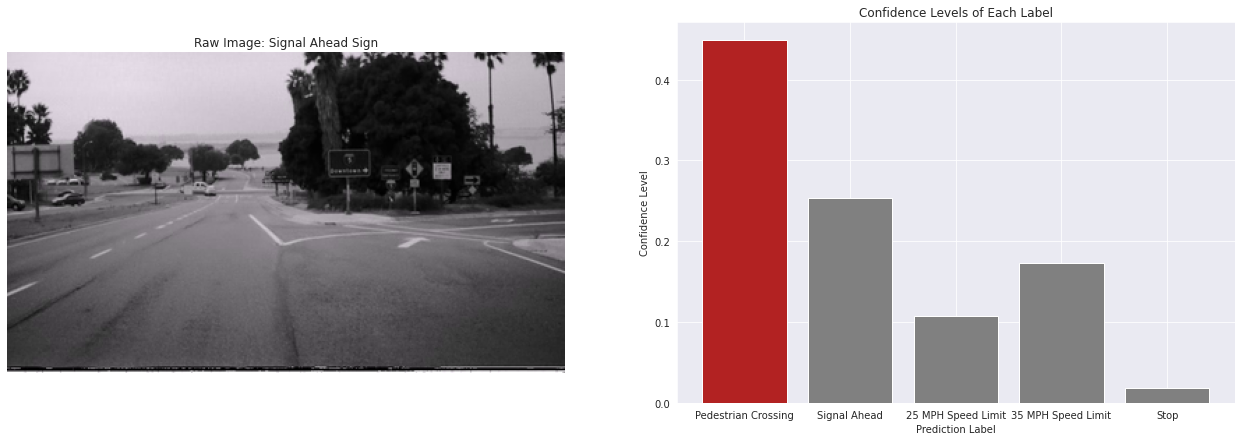

In [0]:
make_prediction_graph('/resized_images_400x230/test/signalAhead/351.png',
                      model)

What causes this? A human can clearly see that this is a signal ahead sign, but what is a computer seeing that makes it think it's a pedestrian crossing sign instead?

To help answer this, we'll make use of [LIME Image Viewer](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb). This is a package that uses colored "superpixels" to help us visualize the classification criteria that the model learns. In other words, it will help us understand the physical parts of the images that contribute positively towards and negatively against the predicted label.

In [0]:
!pip install lime
from IPython.display import clear_output

clear_output()

In [0]:
import lime
from lime import lime_image

The below function, much like the `make_prediction_graph` function from earlier, takes in an image path and a model as inputs, and plots the original image on the left, with the Lime Explained image on the right. 

In [0]:
def get_prediction_label(image_path, model):

  # generating list of predictions using model.predict
  img, img_array = img_path_to_array(image_path)
  preds = model.predict(img_array).tolist()[0]
  
  # inverting key, value pairs in train_generator.class_indices
  label_to_index = train_generator.class_indices
  index_to_label = {v: k for k, v in label_to_index.items()}

  # getting the label associated with the highest confidence level
  max_position = preds.index(max(preds))
  max_label = index_to_label[max_position]

  return max_label

In [0]:
def lime_explain(image_path, model):

  from PIL import Image
  import numpy as np
  from skimage.segmentation import mark_boundaries
  import matplotlib.pyplot as plt

  img, img_array = img_path_to_array(image_path)
  max_label = get_prediction_label(image_path, model)

  # opening image and running it through the LIME explainer
  image = Image.open(image_path)
  image_array = np.asarray(image)
  explainer = lime_image.LimeImageExplainer()

  explanation = explainer.explain_instance(image_array, 
                                           model.predict,
                                           labels=[max_label],
                                           hide_color=0,
                                           num_samples=100)
  
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                              positive_only=False, 
                                              num_features=5, 
                                              hide_rest=False)
  
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,7))

  # settings for raw image on the left
  file_folder = image_path.split('/')[3]
  sign_type = label_dict[file_folder]
  ax1.imshow(img)
  ax1.axis('off')
  ax1.set_title(f'Raw Image: {sign_type} Sign')

  # finally, we grab the prettified label from label_dict
  label = label_dict[max_label]
  ax2.imshow(mark_boundaries(temp, mask))
  ax2.axis('off')
  ax2.set_title(f'LIME Explained Image (Predicted Label: {label_dict[max_label]} Sign)')

  return

We'll test drive this function by plotting the correctly-predicted stop sign picture, just to ensure that the model is predicting Stop Sign based on the physical attributes of a stop sign.

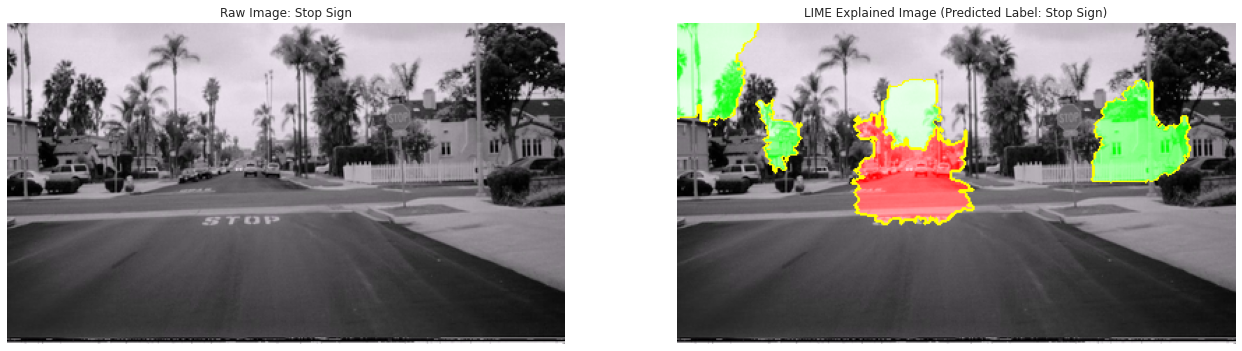

In [0]:
lime_explain('/resized_images_400x230/test/stop/1026.png',
             model)

Uh oh. It seems like the existence of an actual stop sign contributes absolutely nothing to the prediction of one! This is definitely a problem, as we don't want our computers to base their prediction of a stop sign on anything other than a white STOP emblazoned on a red octagon. So, while the model got this prediction correct according to the *label*, Lime has shown us that the model got it wrong according to the *pixels*.

We knew our model could use some tuning, and now we have a visual (and hopefully more visceral) grasp on that fact. We could stop here and dive right back into the model, but let's check the other image in the interest of integrity.

In [0]:
lime_explain('/resized_images_400x230/test/signalAhead/351.png',
             model)

Again, the model is not looking at the sign in order to predict the Pedestrian Crossing class.

## Model #2: Electric Boogaloo

In the interest of higher prediction accuracy, let's create a different neural network in the hopes of increasing our model's prediction ability and reasoning. For this, we'll start with increasing the depth of the model, which will increase training time. To counteract this, we'll follow up with increasing our kernel size in the first layer to train more quickly. We'll add additional layers in the Dense block as well. Finally, in order to obtain a slightly higher level of generalizability, we'll make our dropout layers more aggressive.

In [0]:
model_2 = models.Sequential([
          layers.Conv2D(32, (7, 7), activation='relu',
                        input_shape=(230,400,3)),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(64, (5, 5), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(128, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(128, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(256, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(256, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Flatten(),
          layers.Dense(64, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(256, activation='relu'),
          layers.Dense(512, activation='relu'),
          layers.Dense(512, activation='relu'),
          layers.Dense(1024, activation='relu'),
          layers.Dense(5, activation='softmax')
])


We'll change up the CSV log file name for distinguishing between models.

In [0]:
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log_2.csv')]
callbacks_list

In [0]:
model_2.compile(loss='categorical_crossentropy',
                optimizer="sgd",
                metrics=['acc'])

In [0]:
history_2 = model_2.fit(train_generator, 
                        steps_per_epoch=(train_count//train_batch_size), 
                        epochs=25, 
                        validation_data=validation_generator, 
                        validation_steps=test_count//val_batch_size,
                        callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 20 steps
Epoch 1/25
124/125 [============================>.] - ETA: 0s - loss: 1.4815 - acc: 0.3812
Epoch 00001: val_acc improved from -inf to 0.29000, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-01-0.29.hdf5
125/125 [==============================] - 74s 592ms/step - loss: 1.4805 - acc: 0.3819 - val_loss: 1.5820 - val_acc: 0.2900
Epoch 2/25
124/125 [============================>.] - ETA: 0s - loss: 1.4597 - acc: 0.3868
Epoch 00002: val_acc did not improve from 0.29000
125/125 [==============================] - 72s 576ms/step - loss: 1.4607 - acc: 0.3861 - val_loss: 1.5848 - val_acc: 0.2400
Epoch 3/25
124/125 [============================>.] - ETA: 0s - loss: 1.4534 - acc: 0.3879
Epoch 00003: val_acc did not improve from 0.29000
125/125 [==============================] - 72s 577ms/step - loss: 1.4542 - acc: 0.3869 - val_loss: 1.5897 - val_acc: 0.2400
Epoch 4/25
124/125 [========

In [0]:
# loading model_2 from callback file
model_2 = models.load_model('/models/weights-improvement-01-0.29.hdf5')

A more complex model yielded a much lower validation accuracy of 29%, which is barely better than random guessing. Let's check the predictions and Lime explanations for the same images as before.

In [0]:
make_prediction_graph('/resized_images_400x230/test/stop/1026.png',
                      model_2)

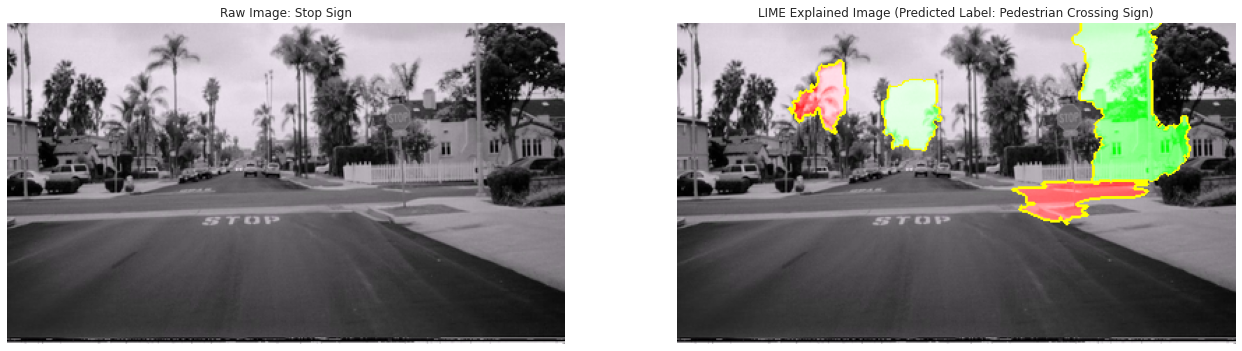

In [0]:
lime_explain('/resized_images_400x230/test/stop/1026.png',
             model_2)

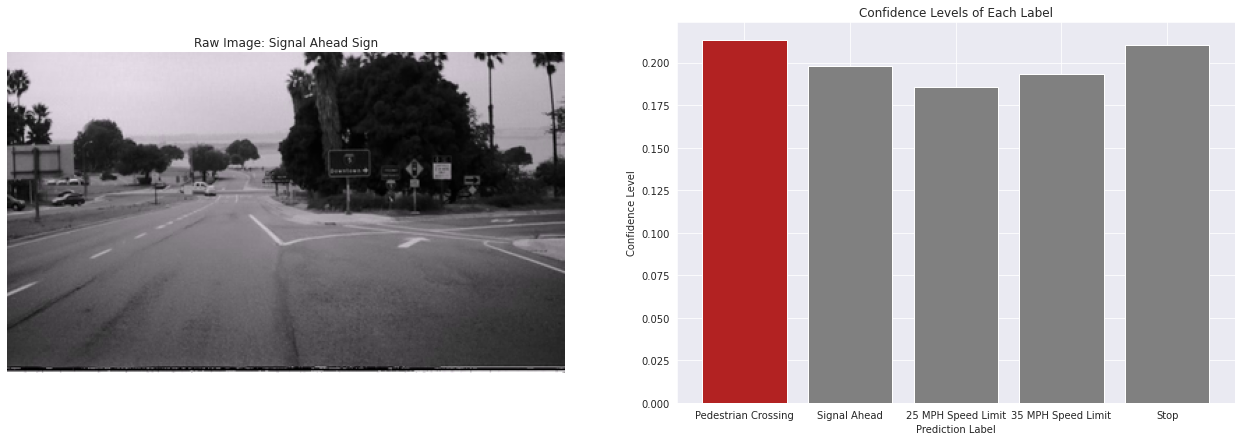

In [0]:
make_prediction_graph('/resized_images_400x230/test/signalAhead/351.png',
                      model_2)

In [0]:
lime_explain('/resized_images_400x230/test/signalAhead/351.png',
             model_2)

It is interesting how, in the first case, the sign itself is not present in the "positive" superpixels that contribute to the model's (usually incorrect) prediction. It's as though our model would misclassify a pile of laundry as a cat based solely on the presence of a litterbox. 

In the second case, however, the model is *looking* at the sign, but still getting the classification wrong. In both cases, however, despite the higher depth of the model, it is much less confident in its responses.

One of the ways of rectifying this problem is to vastly increase the amount and variety of training data, in the hopes of the model nailing down precisely what a traffic sign looks like on its own. It's no secret that all or nearly all of the data in the LISA dataset comes from urban California, and introducing some other landscapes into the mix would, at the very least, help our model distinguish what a traffic sign *isn't*, which is palm trees and blue sky. 

## Model #3: Transfer Learning

Increasing our data is outside the scope of this project (for now), but what about transfer learning? There's no need to climb that mountain if someone else already built an escalator, right?

In [0]:
from tensorflow.keras.applications import VGG19

cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(230, 400, 3))

# Define Model Architecture
model_3 = models.Sequential([
                 cnn_base,
                 layers.Flatten(),
                 layers.Dense(64, activation='relu'),
                 layers.Dense(128, activation='relu'),
                 layers.Dense(256, activation='relu'),
                 layers.Dense(512, activation='relu'),
                 layers.Dense(5, activation='softmax')
])

cnn_base.trainable = False

for layer in model_3.layers:
    print(layer.name, layer.trainable)
    
print(len(model_3.trainable_weights))

model_3.summary()

vgg19 False
flatten_9 True
dense_51 True
dense_52 True
dense_53 True
dense_54 True
dense_55 True
10
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 12, 512)        20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 43008)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                2752576   
_________________________________________________________________
dense_52 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_53 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_54 (Dense)             (None, 512)               131584    
____________________

In [0]:
model_3.compile(loss='categorical_crossentropy',
                optimizer="sgd",
                metrics=['acc'])

In [0]:
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log_3.csv')]
callbacks_list

In [0]:
history_3 = model_3.fit(train_generator, 
                        steps_per_epoch=(train_count//train_batch_size), 
                        epochs=25, 
                        validation_data=validation_generator, 
                        validation_steps=test_count//val_batch_size,
                        callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 20 steps
Epoch 1/25
124/125 [============================>.] - ETA: 0s - loss: 1.4659 - acc: 0.3863
Epoch 00001: val_acc improved from -inf to 0.40000, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-01-0.40.hdf5
125/125 [==============================] - 76s 610ms/step - loss: 1.4651 - acc: 0.3880 - val_loss: 1.3592 - val_acc: 0.4000
Epoch 2/25
124/125 [============================>.] - ETA: 0s - loss: 1.3771 - acc: 0.4176
Epoch 00002: val_acc improved from 0.40000 to 0.40500, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-02-0.41.hdf5
125/125 [==============================] - 76s 608ms/step - loss: 1.3783 - acc: 0.4166 - val_loss: 1.3407 - val_acc: 0.4050
Epoch 3/25
124/125 [============================>.] - ETA: 0s - loss: 1.3278 - acc: 0.4578
Epoch 00003: val_acc did not improve from 0.40500
125/125 [==============================] - 75s 603ms/step - loss:

In [0]:
model_3 = models.load_model('/models/weights-improvement-08-0.64.hdf5')

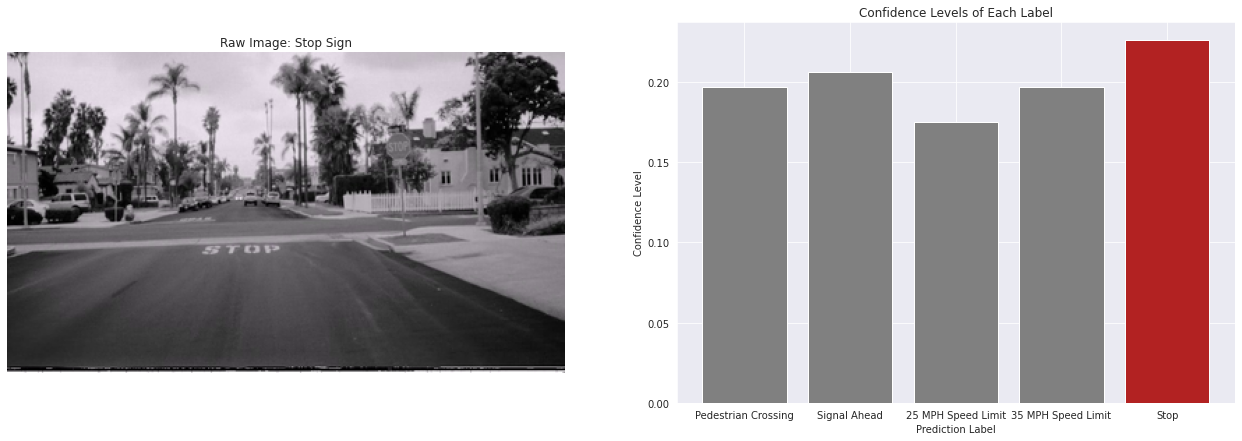

In [0]:
make_prediction_graph('/resized_images_400x230/test/stop/1026.png',
                      model_3)

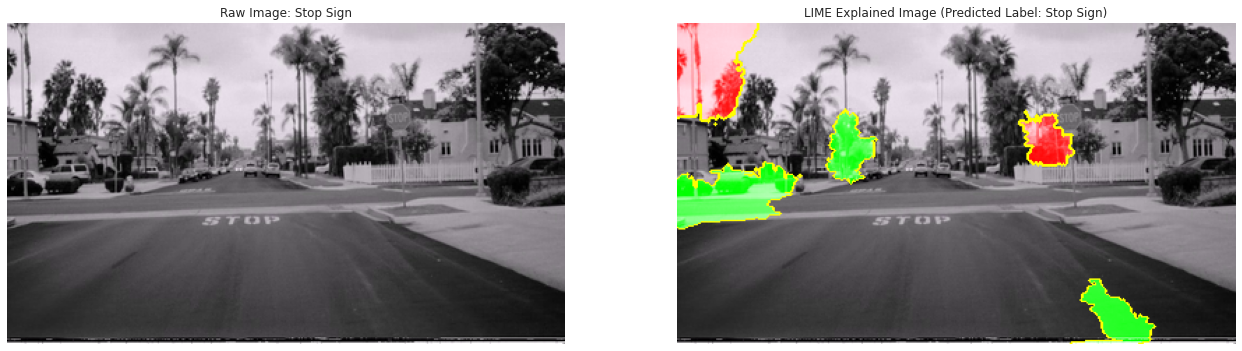

In [0]:
lime_explain('/resized_images_400x230/test/stop/1026.png',
             model_3)

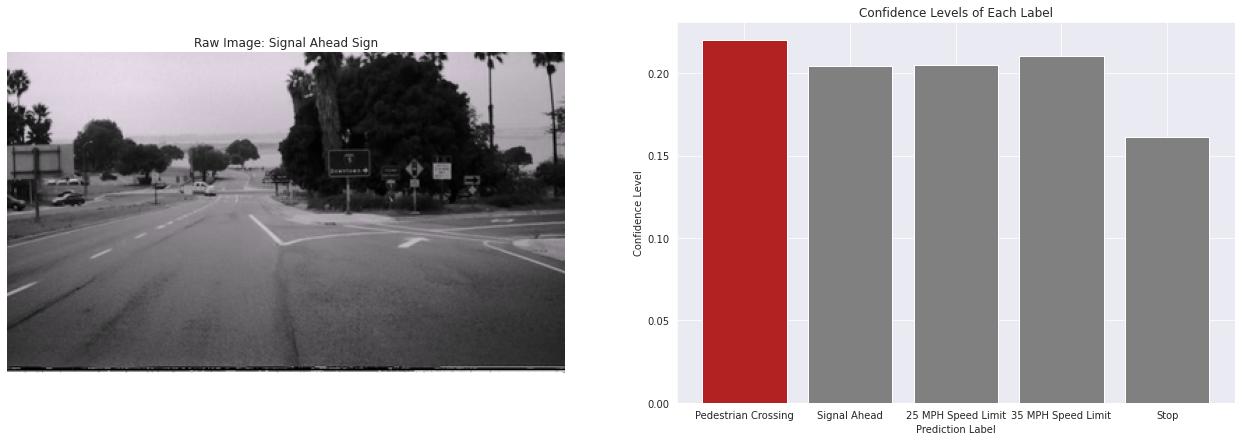

In [0]:
make_prediction_graph('/resized_images_400x230/test/signalAhead/351.png',
                      model_3)

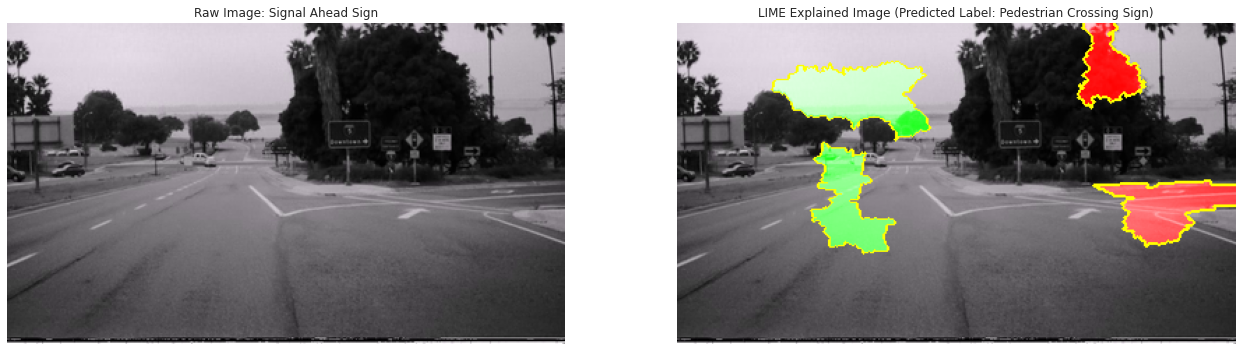

In [0]:
lime_explain('/resized_images_400x230/test/signalAhead/351.png',
             model_3)

As with the previous model, the pretrained model is significantly less confident in its answers. There is still no improvement on identifying the correct superpixels (and in fact, the third model doesn't look at the signal ahead sign at all), but the fact that the label predictions are less confident is an indication that there isn't enough diversity in the data to reliably distinguish between the different traffic signs.

While the pictures we've visualized so far are effectively grayscale, despite being stored as RGB, we also have true color images within the LISA dataset as well. Let's take a look at a couple of them.

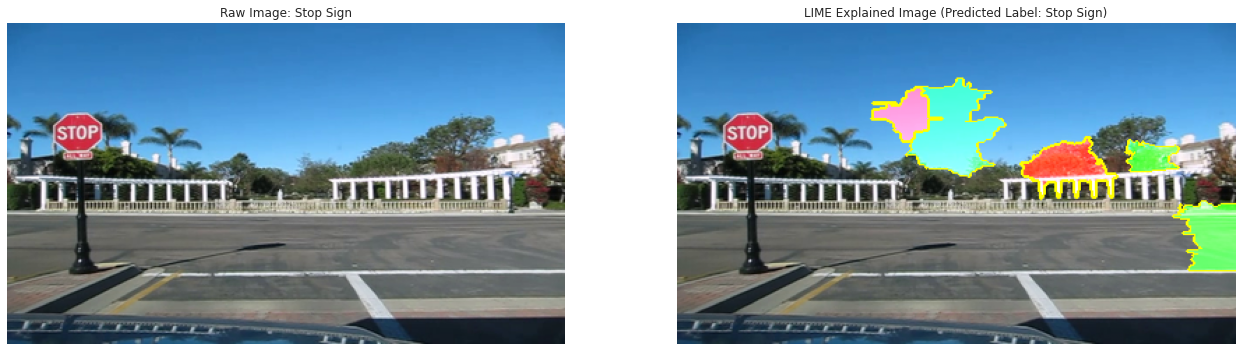

In [0]:
lime_explain('/resized_images_400x230/test/stop/3905.png',
             model_3)

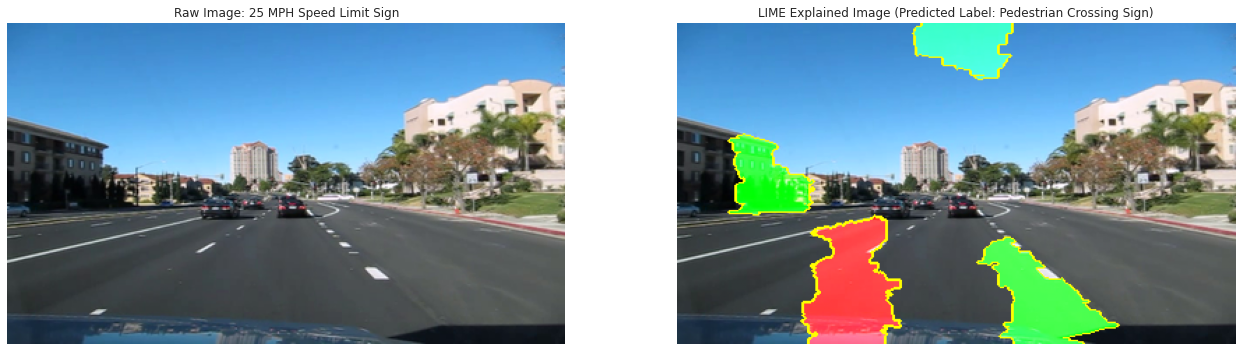

In [0]:
lime_explain('/resized_images_400x230/test/speedLimit25/3936.png',
             model_3)

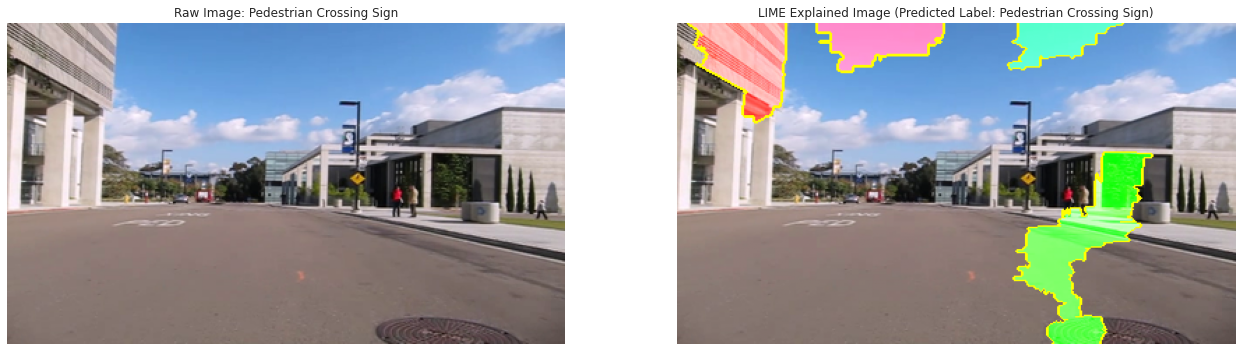

In [0]:
lime_explain('/resized_images_400x230/test/pedestrianCrossing/3719.png',
             model_3)

There doesn't seem to be any difference; the models fail to look at the sign itself in both types of pictures. 

# Applying Models to Different Resolutions

Up until now, we've used pictures only coming from the LISA dataset. What if we used a set of different pictures obtained from Google Street View instead? Would the model do better or worse?

In [0]:
test_generator = test_datagen.flow_from_directory('/prediction_images/prediction', 
                                                  target_size=(230, 400), 
                                                  batch_size=55, 
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 55 images belonging to 5 classes.


In [0]:
# we'll need a slightly different set of functions for prediction viewing

def get_test_pred_label(pic_idx, model):

  preds = model.predict(test_generator, steps=1)[pic_idx].tolist()

  # inverting key, value pairs in train_generator.class_indices
  label_to_index = train_generator.class_indices
  index_to_label = {v: k for k, v in label_to_index.items()}

  # getting the highest confidence level and its associated label
  max_conf = max(preds)
  max_position = preds.index(max_conf)
  max_label = index_to_label[max_position]

  return max_label, max_conf

def lime_explain_preds(pic_idx, model):

  from skimage.segmentation import mark_boundaries

  max_label, max_conf = get_test_pred_label(pic_idx, model)
  
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(test_generator[0][0][pic_idx], 
                                           model.predict, 
                                           labels=[max_label], 
                                           hide_color=0, 
                                           num_samples=100)

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                              positive_only=False, 
                                              num_features=5, 
                                              hide_rest=False)

  label = label_dict[max_label]

  fig = plt.figure(figsize=(11,7))
  plt.imshow(mark_boundaries(temp, mask))
  plt.axis('off')
  plt.title(f'Predicted Label: {label} Sign (Confidence: {round(max_conf*100,1)}%)')
  plt.show()
  

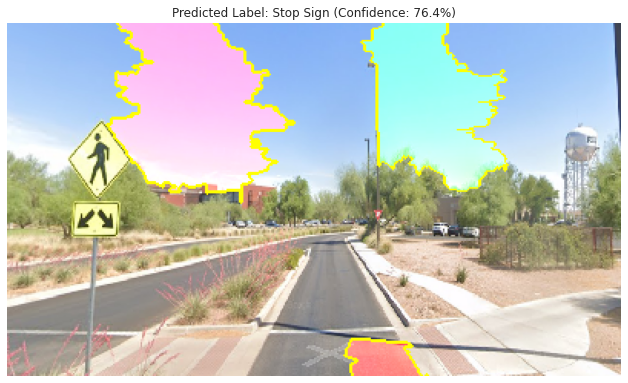

In [0]:
lime_explain_preds(0, model=model)

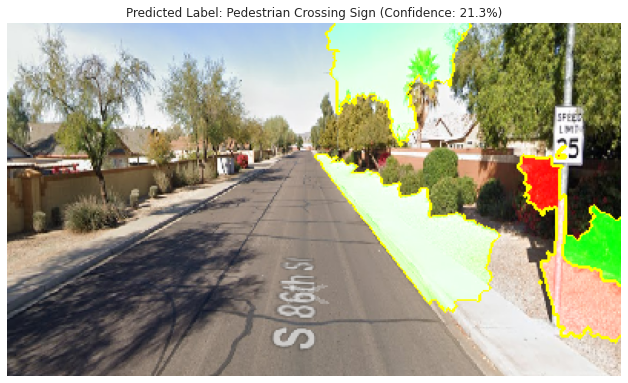

In [0]:
lime_explain_preds(27, model=model_2)

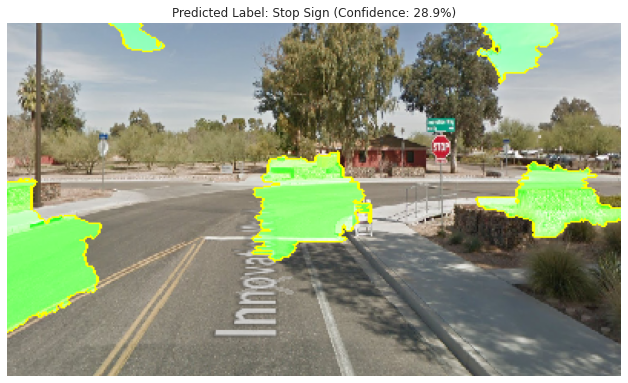

In [0]:
lime_explain_preds(54, model=model_3)

As expected, we see the same behavior from the models on a variety of testing images as well. Each model appears not to take into consideration the actual sign (or the full sign) when predicting the associated label. 

# Summary & Conclusions

We saw a set of models, both scratch-written and pre-trained, that achieved varying yet significant levels of accuracy in determining traffic sign types. Using Lime, however, we were able to see that the sign itself rarely, if ever, contributed to the predictions made by any of the models. Instead, features like roads, trees, cars, and even patches of sky were ultimately deemed more significant in the prediction process. 

A major point of consideration, with regards to model accuracy, is that the LISA dataset is a rather small one; it contains fewer than 8000 pictures with traffic signs in it. Further still, we were only using a fraction of it; 3,757 images were used for training, with 211 set aside for validation. One notable thing that all of the pictures within this dataset have in common is the traffic sign in question taking up a very small fraction of the picture's total area. 

Both of these two points mean that we effectively set out to create models that were capable of teaching themselves, *in just a few thousand examples*, how to ignore more than 90% of the total area of a picture. Anyone familiar with machine learning in general will understand how Herculean this task is. Either we must cut down on the total area of the pictures used for training and validation, or we must vastly increase the total number of training and validation examples. 


# Recommendations and Future Work

Where do we go from here? Now that we know that simple convolutional neural networks require that training examples either be vast in quantity, or they must consist solely of the traffic sign itself, we can begin a two-pronged approach. The first prong is obvious; tailor our data collection process to the CNNs we've created above. However, if we desire a model that is able to use the above data to distinguish between signs using the features of the signs themselves, rather than the surrounding area, we're going to need a different set of modeling techniques altogether. Thus, we arrive at a shortlist of actionable recommendations:

1. Use images that do not share background features such as landscaping or other context.
2. Create bounding box data, or use datasets that have bounding box features.
3. Choose a model architecture that natively incorporates bounding boxes.

This combined approach will produce a model that is not only more accurate, but a model that will output sign location as part of the prediction process. 

Autonomous vehicle companies, such as Uber and Waymo, already do this, as they possess the resources to not only create datasets large enough to reliably train object detection models, but to create models much more robust and nuanced than the ones seen in this project. Far be it from the open-source community, much less myself in particular, to take a peek at these closely-guarded models, but all hope is not lost in creating algorithms more capable of making the right decisions for the right reasons. Algorithms such as [YOLO](https://github.com/ultralytics/yolov3) and [Faster RCNN](https://arxiv.org/abs/1506.01497) are capable of isolating the spatial location of signs and other objects within pictures. In a future update, we'll take a further look at how including things like bounding boxes can create much more robust and accurate modeling without sacrificing the rest of the training picture. 
